# Import Modules & Util Functions

In [1]:
import os
import sys
import glob
import re
import ast
import warnings

import csv
import json
import pickle

import math
import random
import numpy as np
import scipy as sp
import datetime as dt
import pandas as pd
import swifter
from scipy.stats import gaussian_kde
from scipy.integrate import quad

import portion as P
import itertools as it
import copy
from tqdm.notebook import tqdm
from collections import namedtuple
from pprint import pprint
from pytictoc import TicToc

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Configure display options
# pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
%config InlineBackend.figure_format = 'retina'

# Set plot style
# plt.style.use('ggplot')


def data_loader(
    mode='sr', query_dates=False, show_info=False,
    selected_dates=[], selected_exps=[], selected_routes=[],
    excluded_dates=[], excluded_exps=[], excluded_routes=[],
    root_dir='/Users/jackbedford/Desktop/MOXA/Code/data'):
    
    # Collect experiment dates
    dates = [s for s in sorted(os.listdir(root_dir)) if os.path.isdir(os.path.join(root_dir, s)) and s not in ['backup']]
    
    if query_dates:
        if show_info:
            date_dirs = [os.path.join(root_dir, s) for s in dates]
            for date, date_dir in zip(dates, date_dirs):
                date = os.path.basename(date_dir)
                
                # Specify path to JSON file
                json_filepath = os.path.join(date_dir, f'{date}.json')
                
                # Read the JSON file and load its contents into a dictionary
                with open(json_filepath, 'r', encoding='utf-8') as json_file:
                    my_dict = json.load(json_file)
                
                # If the JSON file is empty, then continue
                if not my_dict:
                    continue
                
                print(date, len(my_dict))
                for exp, item in my_dict.items():
                    print({exp: item})
                
        return dates
    
    # Collect experiments
    date_dirs = [os.path.join(root_dir, s) for s in selected_dates if s not in excluded_dates]
    exps_dict = {}
    
    for date_dir in date_dirs:
        date = os.path.basename(date_dir)
                
        # Specify path to JSON file
        json_filepath = os.path.join(date_dir, f'{date}.json')
        
        # Read the JSON file and load its contents into a dictionary
        with open(json_filepath, 'r', encoding='utf-8') as json_file:
            my_dict = json.load(json_file)
        
        # If the JSON file is empty, then continue
        if not my_dict:
            continue
        
        for i, (exp, item) in enumerate(my_dict.items()):
            if len(selected_exps) != 0 and exp not in selected_exps:
                continue
            if len(excluded_exps) != 0 and exp in excluded_exps:
                continue
            if len(selected_routes) != 0 and item['route'] not in selected_routes:
                continue
            if len(excluded_routes) != 0 and item['route'] in excluded_routes:
                continue
            try:
                exps_dict[date] = {**exps_dict[date], **{exp: item}}
            except:
                exps_dict[date] = {exp: item}
    
    if show_info:            
        for date, exps in exps_dict.items():
            print(date, len(exps))
            for exp_name, exp in exps.items():
                print({exp_name: exp})
    
    filepaths = []
    if mode == 'sr':
        for date, exps in exps_dict.items():
            # print(date, len(exps))
            
            for exp_name, exp in exps.items():
                exp_dir = os.path.join(root_dir, date, exp_name)
                # print({exp_name: exp})
                
                devices = list(exp['devices'].keys())
                trips = ['#{:02d}'.format(s[0]) for s in exp['ods'][1:]]
                for trip in trips:
                    for dev in devices:
                        data_dir = os.path.join(exp_dir, dev, trip, 'data')
                        filepaths.append([
                            os.path.join(data_dir, 'handover_info_log.csv'),
                            os.path.join(data_dir, 'udp_dnlk_loss_latency.csv'),
                            os.path.join(data_dir, 'udp_uplk_loss_latency.csv'),
                            os.path.join(data_dir, [s for s in os.listdir(data_dir) if s.endswith('rrc.csv')][0]),
                            os.path.join(data_dir, [s for s in os.listdir(data_dir) if s.endswith('ml1.csv') and not s.endswith('nr_ml1.csv')][0]),
                            os.path.join(data_dir, [s for s in os.listdir(data_dir) if s.endswith('nr_ml1.csv')][0]),
                            ])
    elif mode == 'dr':
        for date, exps in exps_dict.items():
            # print(date, len(exps))
            
            for exp_name, exp in exps.items():
                exp_dir = os.path.join(root_dir, date, exp_name)
                # print({exp_name: exp})
                
                devices = list(exp['devices'].keys())
                combos = list(it.combinations(devices, 2))
                trips = ['#{:02d}'.format(s[0]) for s in exp['ods'][1:]]
                for trip in trips:
                    for dev1, dev2 in combos:
                        data_dir1 = os.path.join(exp_dir, dev1, trip, 'data')
                        data_dir2 = os.path.join(exp_dir, dev2, trip, 'data')
                        _filepaths = []
                        for i in range(2):
                            _filepaths.append([
                                os.path.join(locals()[f'data_dir{i+1}'], 'handover_info_log.csv'),
                                os.path.join(locals()[f'data_dir{i+1}'], 'udp_dnlk_loss_latency.csv'),
                                os.path.join(locals()[f'data_dir{i+1}'], 'udp_uplk_loss_latency.csv'),
                                os.path.join(locals()[f'data_dir{i+1}'], [s for s in os.listdir(locals()[f'data_dir{i+1}']) if s.endswith('rrc.csv')][0]),
                                os.path.join(locals()[f'data_dir{i+1}'], [s for s in os.listdir(locals()[f'data_dir{i+1}']) if s.endswith('ml1.csv') and not s.endswith('nr_ml1.csv')][0]),
                                os.path.join(locals()[f'data_dir{i+1}'], [s for s in os.listdir(locals()[f'data_dir{i+1}']) if s.endswith('nr_ml1.csv')][0]),
                            ])
                        filepaths.append(tuple(_filepaths))
    return filepaths


def data_aligner(df, ho_df):
    empty_data = False
    
    if df.empty or ho_df.empty:
        empty_data = True
        return df, ho_df, empty_data
    
    start_ts = df.iloc[0]['Timestamp'] - pd.Timedelta(seconds=1)
    end_ts = df.iloc[-1]['Timestamp'] + pd.Timedelta(seconds=1)
    ho_df = ho_df[(ho_df['start'] >= start_ts) & (ho_df['start'] < end_ts)].reset_index(drop=True)
    
    if ho_df.empty:
        empty_data = True
        return df, ho_df, empty_data
    
    start_ts = ho_df.iloc[0]['start'] - pd.Timedelta(seconds=100)
    end_ts = ho_df.iloc[-1]['start'] + pd.Timedelta(seconds=100)
    df = df[(df['Timestamp'] >= start_ts) & (df['Timestamp'] < end_ts)].reset_index(drop=True)
    
    return df, ho_df, empty_data


def data_consolidator(df1, df2, ho_df1, ho_df2):
    empty_data = False
    
    df1, ho_df1, empty_data1 = data_aligner(df1, ho_df1)
    df2, ho_df2, empty_data2 = data_aligner(df2, ho_df2)
    if empty_data1 or empty_data2:
        empty_data = True
        return None, df1, df2, ho_df1, ho_df2, empty_data
    
    df = pd.merge(df1, df2, on='seq', how='inner').reset_index(drop=True)
    df1 = df[['seq', 'Timestamp_x', 'lost_x', 'excl_x', 'latency_x']].rename(columns={'Timestamp_x': 'Timestamp', 'lost_x': 'lost', 'excl_x': 'excl', 'latency_x': 'latency'})
    df2 = df[['seq', 'Timestamp_y', 'lost_y', 'excl_y', 'latency_y']].rename(columns={'Timestamp_y': 'Timestamp', 'lost_y': 'lost', 'excl_y': 'excl', 'latency_y': 'latency'})
    df1, ho_df1, _ = data_aligner(df1, ho_df1)
    df2, ho_df2, _ = data_aligner(df2, ho_df2)
    
    return df, df1, df2, ho_df1, ho_df2, empty_data

# Demo: Select & Read Data From Database

In [2]:
# Single Radio Example
dates = data_loader(query_dates=True)

selected_dates = [s for s in dates if s >= '2023-09-12']
# excluded_dates = []
# selected_exps = []
# excluded_exps = ['Modem_Action_Test', 'Control_Group', 'Control_Group2', 'Control_Group3']
# selected_routes = ['BR']
# excluded_routes = []
filepaths = data_loader(mode='sr', selected_dates=selected_dates)

filepath = filepaths[0]
pprint(filepath)

ho_df = pd.read_csv(filepath[0], parse_dates=['start', 'end'])
df = pd.read_csv(filepath[1], parse_dates=['Timestamp'])[['seq', 'Timestamp', 'lost', 'excl', 'latency']]
df, ho_df, empty_data = data_aligner(df, ho_df)

df

['/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/handover_info_log.csv',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/udp_dnlk_loss_latency.csv',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/udp_uplk_loss_latency.csv',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/diag_log_sm00_2023-09-12_13-34-15_rrc.csv',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/diag_log_sm00_2023-09-12_13-34-15_ml1.csv',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/diag_log_sm00_2023-09-12_13-34-15_nr_ml1.csv']


,seq,Timestamp,lost,excl,latency
0,2501,2023-09-12 13:34:16.245625,False,False,0.015184
1,2502,2023-09-12 13:34:16.247625,False,False,0.013184
2,2503,2023-09-12 13:34:16.249625,False,False,0.016496
3,2504,2023-09-12 13:34:16.251626,False,False,0.014495
4,2505,2023-09-12 13:34:16.253626,False,False,0.012495
...,...,...,...,...,...
1417486,1419987,2023-09-12 14:21:31.350104,False,False,-0.013385
1417487,1419988,2023-09-12 14:21:31.352104,False,False,-0.009389
1417488,1419989,2023-09-12 14:21:31.354104,False,False,-0.011389
1417489,1419990,2023-09-12 14:21:31.356104,False,False,-0.013389


In [3]:
# Dual Radio Example
dates = data_loader(query_dates=True)

selected_dates = [s for s in dates if s >= '2023-09-12']
# excluded_dates = []
# selected_exps = []
# excluded_exps = ['Modem_Action_Test', 'Control_Group', 'Control_Group2', 'Control_Group3']
# selected_routes = ['BR']
# excluded_routes = []
filepaths = data_loader(mode='dr', selected_dates=selected_dates)

filepath = filepaths[0]
pprint(filepath)

ho_df1 = pd.read_csv(filepath[0][0], parse_dates=['start', 'end'])
ho_df2 = pd.read_csv(filepath[1][0], parse_dates=['start', 'end'])
df1 = pd.read_csv(filepath[0][1], parse_dates=['Timestamp'])[['seq', 'Timestamp', 'lost', 'excl', 'latency']]
df2 = pd.read_csv(filepath[1][1], parse_dates=['Timestamp'])[['seq', 'Timestamp', 'lost', 'excl', 'latency']]
df, df1, df2, ho_df1, ho_df2, empty_data = data_consolidator(df1, df2, ho_df1, ho_df2)

df

(['/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/handover_info_log.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/udp_dnlk_loss_latency.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/udp_uplk_loss_latency.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/diag_log_sm00_2023-09-12_13-34-15_rrc.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/diag_log_sm00_2023-09-12_13-34-15_ml1.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/diag_log_sm00_2023-09-12_13-34-15_nr_ml1.csv'],
 ['/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/handover_info_log.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UD

,seq,Timestamp_x,lost_x,excl_x,latency_x,Timestamp_y,lost_y,excl_y,latency_y
0,2501,2023-09-12 13:34:16.245625,False,False,0.015184,2023-09-12 13:34:16.245625,False,False,0.006932
1,2502,2023-09-12 13:34:16.247625,False,False,0.013184,2023-09-12 13:34:16.247625,False,False,0.010498
2,2503,2023-09-12 13:34:16.249625,False,False,0.016496,2023-09-12 13:34:16.249625,False,False,0.008498
3,2504,2023-09-12 13:34:16.251626,False,False,0.014495,2023-09-12 13:34:16.251626,False,False,0.006497
4,2505,2023-09-12 13:34:16.253626,False,False,0.012495,2023-09-12 13:34:16.253626,False,False,0.010151
...,...,...,...,...,...,...,...,...,...
1417486,1419987,2023-09-12 14:21:31.350104,False,False,-0.013385,2023-09-12 14:21:31.350104,False,False,0.003973
1417487,1419988,2023-09-12 14:21:31.352104,False,False,-0.009389,2023-09-12 14:21:31.352104,False,False,0.001973
1417488,1419989,2023-09-12 14:21:31.354104,False,False,-0.011389,2023-09-12 14:21:31.354104,False,False,-0.000027
1417489,1419990,2023-09-12 14:21:31.356104,False,False,-0.013389,2023-09-12 14:21:31.356104,False,False,-0.002027


# Single Radio Profiling

In [4]:
# Single Radio Example
dates = data_loader(query_dates=True)

selected_dates = [s for s in dates if s >= '2023-09-12']
# excluded_dates = []
# selected_exps = []
# excluded_exps = ['Modem_Action_Test', 'Control_Group', 'Control_Group2', 'Control_Group3']
selected_routes = ['BR', 'A']
# excluded_routes = []
filepaths = data_loader(mode='sr', selected_dates=selected_dates, selected_routes=selected_routes)
print(len(filepaths))
pprint(filepaths)

108
[['/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/handover_info_log.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/udp_dnlk_loss_latency.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/udp_uplk_loss_latency.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/diag_log_sm00_2023-09-12_13-34-15_rrc.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/diag_log_sm00_2023-09-12_13-34-15_ml1.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/diag_log_sm00_2023-09-12_13-34-15_nr_ml1.csv'],
 ['/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/handover_info_log.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-

In [5]:
class Profile():
    def __init__(self, filepaths, 
                 scope_agg=None, scope=None, sp_columns=['type'], ts_column='Timestamp',
                 metrics=['dl_lost', 'dl_excl', 'ul_lost', 'ul_excl']):
        # Initialize instance variables
        self.filepaths = copy.deepcopy(filepaths)
        if scope_agg is None:
            if scope is None:
                scope = {
                    **{key: (-5.0, 5.0) for key in ['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGR-II', 'SCGC-I', 'SCGC-II']},
                    **{key: (-10.0, 10.0) for key in ['SCGF', 'MCGF', 'NASR']}, 
                    'Stable': (-1.0, 1.0)
                }
            self.scope_agg = { mode_mets: scope.copy() for mode_mets in metrics }   
        else:
            self.scope_agg = scope_agg.deepcopy()
        self.sp_columns = sp_columns[:]
        self.ts_column = ts_column
        self.metrics = metrics[:]
        self.Container = { mode_mets: { tag: { 'dist_table': [],
                                               'relative_loex_timestamp': [],
                                               'relative_timestamp': [],
                                               'interruption_time': [],
                                               'trigger_loex': [],
                                               'event_count': [] } 
                                        for tag in self.scope_agg[mode_mets].keys() }
                                        for mode_mets in metrics }
        self.Profile = { mode_mets: { tag: { 'dist_table': None,
                                             'relative_loex_timestamp': [],
                                             'relative_timestamp': [],
                                             'interruption_time': [],
                                             'trigger_loex': [],
                                             'event_count': 0 } 
                                        for tag in self.scope_agg[mode_mets].keys() }
                                        for mode_mets in metrics }
        # Construct profiles
        self.construct_profile()
    
    
    @staticmethod
    def interpolate(x, y, ratio=0.5):
        """
        Args:
            x, y (datetime.datetime): x < y
            ratio (float): a decimal numeral in a range [0, 1]; 0 means break at x, 1 means break at y.
        Returns:
            (datetime.datetime): breakpoint of interpolation
        """
        return x + (y - x) * ratio
    
    
    def create_instance(self, df, center, interval, mets='lost', w_size=0.01):
        df = df[(df[self.ts_column] >= interval.lower) & (df[self.ts_column] < interval.upper)].copy().reset_index(drop=True)
        
        # Relative window converted from timestamp
        df['relative_time'] = (df['Timestamp'] - center).dt.total_seconds()
        df['window_id'] = ((df['relative_time'] + w_size / 2) // w_size) * w_size  # 四捨五入
        
        if mets == 'lost':
            RATE_TYPE = 'PLR'
            loex_df = df[df['lost']].copy()
            ts_group = df.groupby(['window_id'])
            table = ts_group.agg({'lost': ['count','sum'], 'Timestamp': ['first']}).reset_index()
        elif mets == 'excl':
            RATE_TYPE = 'ELR'
            df['excl_exact'] = df['excl'] & ~df['lost']
            loex_df = df[df['excl_exact']].copy()
            ts_group = df.groupby(['window_id'])
            table = ts_group.agg({'excl_exact': ['count','sum'], 'Timestamp': ['first']}).reset_index()
        
        table.columns = ['window_id','tx_count',mets,'Timestamp']
        
        return table, loex_df['relative_time'].to_list(), df['relative_time'].to_list()
        # return table, loex_df['relative_time'].to_numpy()
    
    
    def setup_profile(self, df, ho_df, mode, mets, scope):
        # Initialize "Register"
        Register = { tag: { 'dist_table': [],
                            'relative_loex_timestamp': [],
                            'relative_timestamp': [],
                            'interruption_time': [],
                            'trigger_loex': [] } for tag in scope.keys() }
        this_df = df.copy()
        
        for i, row in ho_df.iterrows():
            prior_row = ho_df.iloc[i-1] if i != 0 else None
            post_row = ho_df.iloc[i+1] if i != len(ho_df) - 1 else None

            # Peek the next event to avoid HO overlapping with handoverFailure (skip!!)
            if i != len(ho_df) - 1 and pd.notna(row.end) and row.end > post_row.start:
                # print('Overlapping event occurs!!')
                # print(i, row['start'], row['end'], row['type'], row['cause'])
                # print(i+1, post_row['start'], post_row['end'], post_row['type'], post_row['cause'])
                continue
            
            # Set prior event if the prior loop is skipped
            if i != 0 and pd.notna(prior_row.end) and prior_row.end > row.start:
                prior_row = ho_df.iloc[i-2] if i > 1 else None
            
            # Basic information of the current row
            tag = '_'.join([s for s in row[self.sp_columns] if pd.notna(s)])  # specific column name
            start_ts, end_ts = row['start'], row['end']  # handover start/end time
            interruption_time = (end_ts - start_ts).total_seconds() if pd.notna(end_ts) else 0  # handover interruption time
            
            # Set simple left/right bounds
            current_left_bound = start_ts + pd.Timedelta(seconds=(scope[tag][0]))
            current_right_bound = start_ts + pd.Timedelta(seconds=(scope[tag][1]))
            
            # Set left/right bounds to avoid event overlapping with each other
            if prior_row is not None:
                prior_tag = '_'.join([s for s in prior_row[self.sp_columns] if pd.notna(s)])
                prior_right_bound = prior_row['start'] + pd.Timedelta(seconds=(scope[prior_tag][1]))
                if pd.notna(prior_row['end']):
                    # left = prior_row['end'] + (start_ts - prior_row['end']) / 2
                    left_bound = min(max(current_left_bound, Profile.interpolate(prior_right_bound, current_left_bound), prior_row['end']), start_ts)
                else:
                    # left = prior_row['start'] + (start_ts - prior_row['start']) / 2
                    left_bound = min(max(current_left_bound, Profile.interpolate(prior_right_bound, current_left_bound), prior_row['start']), start_ts)
            else:
                # left_bound = pd.Timestamp.min
                left_bound = current_left_bound
            
            if post_row is not None:
                post_tag = '_'.join([s for s in post_row[self.sp_columns] if pd.notna(s)])
                post_left_bound = post_row['start'] + pd.Timedelta(seconds=(scope[post_tag][0]))
                if pd.notna(end_ts):
                    # right = end_ts + (post_row['start'] - end_ts) / 2
                    right_bound = max(min(current_right_bound, Profile.interpolate(current_right_bound, post_left_bound), post_row['start']), end_ts)
                else:
                    # right = start_ts + (post_row['start'] - start_ts) / 2
                    right_bound = max(min(current_right_bound, Profile.interpolate(current_right_bound, post_left_bound), post_row['start']), start_ts)
            else:
                # right_bound = pd.Timestamp.max
                right_bound = current_right_bound
            
            # interval = P.closed(max(start_ts+pd.Timedelta(seconds=scope[tag][0]), left_bound), min(start_ts+pd.Timedelta(seconds=scope[tag][1]), right_bound))
            interval = P.closed(left_bound, right_bound)

            # Consider the stable duration before an event starts
            stable_df = this_df[this_df[self.ts_column] < interval.lower].copy()
            stable_df['Timestamp_to_second'] = stable_df['Timestamp'].dt.floor('S')
            
            if not stable_df.empty:
                unique_timestamps = stable_df['Timestamp_to_second'].unique()
                
                tmp_df = stable_df.copy()
                for ts in unique_timestamps:
                    stable_center = ts + pd.Timedelta(seconds=0.5)
                    stable_interval = P.closed(ts, min(ts + pd.Timedelta(seconds=1), interval.lower))
                    
                    # Create an instance of stable profile
                    # dist_table, relative_loex_timestamp = self.create_instance(tmp_df.copy(), stable_center, stable_interval, mets=mets)
                    dist_table, relative_loex_timestamp, relative_timestamp = self.create_instance(tmp_df.copy(), stable_center, stable_interval, mets=mets)
                    
                    # if len(relative_loex_timestamp):
                    #     display(dist_table)
                    #     print('Stable', len(relative_loex_timestamp), relative_loex_timestamp)
                    
                    # Feed into "Register"
                    if len(relative_loex_timestamp):
                        Register['Stable']['trigger_loex'].append(1)
                        Register['Stable']['dist_table'].append(dist_table)
                        Register['Stable']['relative_loex_timestamp'] += relative_loex_timestamp
                        # Register['Stable']['relative_loex_timestamp'] = np.concatenate((Register['Stable']['relative_loex_timestamp'], relative_loex_timestamp))
                    else:
                        Register['Stable']['trigger_loex'].append(0)
                    Register['Stable']['interruption_time'].append((stable_interval.upper - stable_interval.lower).total_seconds())
                    Register['Stable']['relative_timestamp'] += relative_timestamp
                    
                    # Update dataframe to accelerate
                    tmp_df = tmp_df[tmp_df[self.ts_column] >= ts + pd.Timedelta(seconds=1)]
            
            # Create an instance of handover profile
            # dist_table, relative_loex_timestamp = self.create_instance(this_df.copy(), start_ts, interval, mets=mets)
            dist_table, relative_loex_timestamp, relative_timestamp = self.create_instance(this_df.copy(), start_ts, interval, mets=mets)
            
            # if len(relative_loex_timestamp):
            #     display(dist_table)
            #     print(tag, len(relative_loex_timestamp), relative_loex_timestamp)
            
            # Feed into "Register"
            if len(relative_loex_timestamp):
                Register[tag]['trigger_loex'].append(1)
                Register[tag]['dist_table'].append(dist_table)
                Register[tag]['relative_loex_timestamp'] += relative_loex_timestamp
                # Register[tag]['relative_loex_timestamp'] = np.concatenate((Register[tag]['relative_loex_timestamp'], relative_loex_timestamp))
            else:
                Register[tag]['trigger_loex'].append(0)
            Register[tag]['interruption_time'].append(interruption_time)
            Register[tag]['relative_timestamp'] += relative_timestamp
            
            # Update dataframe to accelerate the speed
            this_df = this_df[this_df[self.ts_column] >= interval.upper].copy()

        # Consider the stable duration after the last event ends
        stable_df = this_df.copy()
        stable_df['Timestamp_to_second'] = stable_df['Timestamp'].dt.floor('S')

        if not stable_df.empty:
            unique_timestamps = stable_df['Timestamp_to_second'].unique()
            
            tmp_df = stable_df.copy()
            for ts in unique_timestamps:
                stable_center = ts + pd.Timedelta(seconds=0.5)
                stable_interval = P.closed(ts, ts + pd.Timedelta(seconds=1))
                
                # Create an instance of stable profile
                # dist_table, relative_loex_timestamp = self.create_instance(tmp_df.copy(), stable_center, stable_interval, mets=mets)
                dist_table, relative_loex_timestamp, relative_timestamp = self.create_instance(tmp_df.copy(), stable_center, stable_interval, mets=mets)
                
                # if len(relative_loex_timestamp):
                #     display(dist_table)
                #     print('Stable', len(relative_loex_timestamp), relative_loex_timestamp)
                
                # Feed into "Register"
                if len(relative_loex_timestamp):
                    Register['Stable']['trigger_loex'].append(1)
                    Register['Stable']['dist_table'].append(dist_table)
                    Register['Stable']['relative_loex_timestamp'] += relative_loex_timestamp
                    # Register['Stable']['relative_loex_timestamp'] = np.concatenate((Register['Stable']['relative_loex_timestamp'], relative_loex_timestamp))
                else:
                    Register['Stable']['trigger_loex'].append(0)
                Register['Stable']['interruption_time'].append((stable_interval.upper - stable_interval.lower).total_seconds())
                Register['Stable']['relative_timestamp'] += relative_timestamp
                
                # Update dataframe to accelerate
                tmp_df = tmp_df[tmp_df[self.ts_column] >= ts + pd.Timedelta(seconds=1)]
        
        return Register
    
    
    @staticmethod
    def dist_aggregate(tables, mode, mets):
        if mets == 'lost':
            RATE_TYPE = 'PLR'
        elif mets == 'excl':
            RATE_TYPE = 'ELR'
        
        table = pd.DataFrame(columns=['window_id','tx_count',mets])
        table[mets] = table[mets].astype('Int32')
        table['window_id'] = table['window_id'].astype('float32')
        table['tx_count'] = table['tx_count'].astype('Int32')
        
        tables = [t for t in tables if t is not None]
        for this_table in tables:
            table = table.merge(this_table, on=['window_id'], how='outer').fillna(0)
            table['tx_count'] = table['tx_count_x'] + table['tx_count_y']
            table[mets] = table[f'{mets}_x'] + table[f'{mets}_y']
            table = table[['window_id','tx_count',mets]]
        
        table[RATE_TYPE] = table[mets] / (table['tx_count'] + 1e-9) * 100
        table[RATE_TYPE] = table[RATE_TYPE].astype('float32')
        
        table = table[['window_id','tx_count',mets,RATE_TYPE]].copy().sort_values(by=['window_id']).reset_index(drop=True)
        return table
    
    
    @staticmethod
    def mean_downsample(data, sample_size=666666):
        """
        平均下採樣函數
        
        Args:
        data: 原始數據的列表
        sample_size: 下採樣後的樣本大小
        
        Returns:
        downsampled_data: 下採樣後的數據列表
        """
        chunk_size = len(data) // sample_size
        if chunk_size == 0:
            return data
        downsampled_data = [sum(data[i:i+chunk_size]) / chunk_size for i in range(0, len(data), chunk_size)]
        return downsampled_data
    
    
    @staticmethod
    def median_downsample(data, sample_size=666666):
        """
        中位數下採樣函數
        
        Args:
        data: 原始數據的列表
        sample_size: 下採樣後的樣本大小
        
        Returns:
        downsampled_data: 下採樣後的數據列表
        """
        chunk_size = len(data) // sample_size
        if chunk_size == 0:
            return data
        downsampled_data = []
        for i in range(0, len(data), chunk_size):
            chunk = data[i:i+chunk_size]
            median_index = len(chunk) // 2
            median_value = np.median(chunk)
            downsampled_data.append(median_value)
        return downsampled_data


    def construct_profile(self):
        n = len(self.filepaths)
        
        for i, filepath in enumerate(self.filepaths):
            # if i > 0:
            #     break
            
            for s in filepath[:3]:
                print(f'{i+1}/{n}', s)
            
            dl_df, ul_df = None, None
            ho_df = pd.read_csv(filepath[0], parse_dates=['start', 'end'])
            if ho_df.empty:
                print('******** Empty RRC Data ********')
                continue
            
            for mode_mets in self.metrics:
                mode, mets = mode_mets[:2], mode_mets[-4:]
                scope = self.scope_agg[mode_mets]
                
                if mode == 'dl':
                    if dl_df is None:
                        dl_df = pd.read_csv(filepath[1], parse_dates=['Timestamp'])[['seq', 'Timestamp', 'lost', 'excl', 'latency']]
                    df = dl_df.copy()
                elif mode == 'ul':
                    if ul_df is None:
                        ul_df = pd.read_csv(filepath[1], parse_dates=['Timestamp'])[['seq', 'Timestamp', 'lost', 'excl', 'latency']]
                    df = ul_df.copy()
                
                ho_df = pd.read_csv(filepath[0], parse_dates=['start', 'end'])
                df, ho_df, empty_data = data_aligner(df, ho_df)
                
                if empty_data:
                    print('******** Empty Data:', mode_mets, '********')
                    continue
                
                Register = self.setup_profile(df, ho_df, mode, mets, scope)
                
                # Append "Register" for each trace
                for tag in scope.keys():
                    # if len(Register[tag]['interruption_time']) == 0:
                    #     continue
                    
                    table = Profile.dist_aggregate(Register[tag]['dist_table'], mode, mets)
                    self.Container[mode_mets][tag]['dist_table'].append(table)
                    self.Container[mode_mets][tag]['relative_loex_timestamp'].append(Register[tag]['relative_loex_timestamp'])
                    self.Container[mode_mets][tag]['relative_timestamp'].append(Register[tag]['relative_timestamp'])
                    self.Container[mode_mets][tag]['trigger_loex'].append(Register[tag]['trigger_loex'])
                    self.Container[mode_mets][tag]['interruption_time'].append(Register[tag]['interruption_time'])
                    self.Container[mode_mets][tag]['event_count'].append(len(Register[tag]['interruption_time']))
        
        for mode_mets in self.metrics:
            mode, mets = mode_mets[:2], mode_mets[-4:]
            scope = self.scope_agg[mode_mets]
            
            for tag in scope.keys():
                self.Profile[mode_mets][tag]['dist_table'] = Profile.dist_aggregate(self.Container[mode_mets][tag]['dist_table'], mode, mets)
                
                # self.Profile[mode_mets][tag]['relative_loex_timestamp'] = self.Container[mode_mets][tag]['relative_loex_timestamp']
                data = []
                for lst in self.Container[mode_mets][tag]['relative_loex_timestamp']:
                    data += lst
                self.Profile[mode_mets][tag]['relative_loex_timestamp'] = Profile.median_downsample(sorted(data))
                self.Container[mode_mets][tag]['relative_loex_timestamp'] = []
                    
                # self.Profile[mode_mets][tag]['relative_timestamp'] = self.Container[mode_mets][tag]['relative_timestamp']
                data = []
                for lst in self.Container[mode_mets][tag]['relative_timestamp']:
                    data += lst
                self.Profile[mode_mets][tag]['relative_timestamp'] = Profile.median_downsample(sorted(data))
                self.Container[mode_mets][tag]['relative_timestamp'] = []
                    
                # self.Profile[mode_mets][tag]['trigger_loex'] = self.Container[mode_mets][tag]['trigger_loex']
                for lst in self.Container[mode_mets][tag]['trigger_loex']:
                    self.Profile[mode_mets][tag]['trigger_loex'] += lst
                
                # self.Profile[mode_mets][tag]['interruption_time'] = self.Container[mode_mets][tag]['interruption_time']
                for lst in self.Container[mode_mets][tag]['interruption_time']:
                    self.Profile[mode_mets][tag]['interruption_time'] += lst
                
                # self.Profile[mode_mets][tag]['event_count'] = self.Container[mode_mets][tag]['event_count']
                self.Profile[mode_mets][tag]['event_count'] += sum(self.Container[mode_mets][tag]['event_count'])
    
    
    @staticmethod
    def total_area_kde(kde, lower_bound=-np.inf, upper_bound=np.inf):
        # 定義積分函數
        def integrand(x):
            return kde(x)
        total_area, _ = quad(integrand, lower_bound, upper_bound)
        return total_area

    
    @staticmethod
    def total_area_histogram_with_centers(x_centers, heights, bin_width):
        # 計算每個 bin 的面積並相加
        total_area = bin_width * sum(heights)
        return total_area

    
    @staticmethod
    def plot_example1(tag, table, loex_data, xmit_data, mets, RATE_TYPE) -> bool:
        if tag == 'Stable':
            mean = 0
            left_bound, right_bound = -0.5, 0.5
        else:
            mean, std = np.mean(loex_data), np.std(loex_data)
            left_bound, right_bound = round(mean - 3 * std, 1), round(mean + 3 * std, 1)
        
        fig, ax = plt.subplots(figsize=(6, 4))
        
        x = np.asarray(table['window_id'], dtype=np.float64)
        y = np.asarray(table[RATE_TYPE], dtype=np.float64)
        # y = np.asarray(table[mets], dtype=np.float64)
        ax.bar(x, y, label='hist', width=0.03, alpha=0.97)
        
        # 計算直方圖的面積
        hist_area = Profile.total_area_histogram_with_centers(x, y, 0.01)
        print("Total area of histogram:", hist_area)
        
        # ax_twin = ax.twinx()
        
        # kde1 = gaussian_kde(loex_data)
        # kde2 = gaussian_kde(xmit_data)
        # def kde(x):
        #     kde2_values = kde2(x)
        #     # 檢查 kde2 是否為零，如果是則返回一個小的非零值
        #     kde2_values[kde2_values == 0] = 1
        #     return kde1(x) / kde2_values
        kde = gaussian_kde(loex_data)
        
        # 計算 KDE 下的總面積（只計算正負三個標準差內的點，理論上 scalar 會稍微高估，但不會太多）
        kde_area = Profile.total_area_kde(kde, left_bound, right_bound)
        # 計算 KDE 下的總面積（無窮積分）
        # kde_area = total_area_kde(kde)
        print("Total area under KDE:", kde_area)
        
        scalar = hist_area / kde_area
        print("Scalar:", scalar)
        
        x = np.linspace(min(xmit_data), max(xmit_data), 1000)
        # x = np.linspace(min(loex_data), max(loex_data), 1000)
        
        density = scalar * kde(x)
        # ax.plot(x, density, label='KDE', color='tab:orange', lw=1)
        ax.fill_between(x, density, label='KDE', color='tab:orange', alpha=0.45)
        
        # find the scope and boundaries
        ax.axvline(x=mean, color='red', linestyle='--', label='Mean')
        ax.axvline(x=left_bound, color='blue', linestyle='--', label='-3 Std')
        ax.axvline(x=right_bound, color='blue', linestyle='--', label='+3 Std')
        
        bottom, top = ax.get_ylim()
        ax.text(left_bound, bottom-0.05*(top-bottom), '{:.1f}'.format(left_bound), ha='center', fontweight='bold', fontsize=10, color='blue')
        ax.text(right_bound, bottom-0.05*(top-bottom), '{:.1f}'.format(right_bound), ha='center', fontweight='bold', fontsize=10, color='blue')
        
        ax.legend()
        
        plt.gcf().autofmt_xdate()
        plt.show()
        # break
    
    
    @staticmethod
    def plot_example2(tag, table, loex_data, xmit_data, mets, RATE_TYPE) -> bool:
        if tag == 'Stable':
            mean = 0
            left_bound, right_bound = -0.5, 0.5
        else:
            mean, std = np.mean(loex_data), np.std(loex_data)
            left_bound, right_bound = round(mean - 3 * std, 1), round(mean + 3 * std, 1)
        
        fig, ax = plt.subplots(figsize=(6, 4))
        
        x = np.asarray(table['window_id'], dtype=np.float64)
        y = np.asarray(table[RATE_TYPE], dtype=np.float64)
        # y = np.asarray(table[mets], dtype=np.float64)
        ax.bar(x, y, label='hist', width=0.03, alpha=0.97)
        
        # 計算直方圖的面積
        hist_area = Profile.total_area_histogram_with_centers(x, y, 0.01)
        print("Total area of histogram:", hist_area)
        
        # ax_twin = ax.twinx()
        
        kde1 = gaussian_kde(loex_data)
        kde2 = gaussian_kde(xmit_data)
        def kde(x):
            kde2_values = kde2(x)
            # 檢查 kde2 是否為零，如果是則返回一個小的非零值
            kde2_values[kde2_values == 0] = 1
            return kde1(x) / kde2_values
        # kde = gaussian_kde(loex_data)
        
        # 計算 KDE 下的總面積（只計算正負三個標準差內的點，理論上 scalar 會稍微高估，但不會太多）
        kde_area = Profile.total_area_kde(kde, left_bound, right_bound)
        # 計算 KDE 下的總面積（無窮積分）
        # kde_area = total_area_kde(kde)
        print("Total area under KDE:", kde_area)
        
        scalar = hist_area / kde_area
        print("Scalar:", scalar)
        
        x = np.linspace(min(xmit_data), max(xmit_data), 1000)
        # x = np.linspace(min(loex_data), max(loex_data), 1000)
        
        density = scalar * kde(x)
        # ax.plot(x, density, label='KDE', color='tab:orange', lw=1)
        ax.fill_between(x, density, label='KDE', color='tab:orange', alpha=0.45)
        
        # find the scope and boundaries
        ax.axvline(x=mean, color='red', linestyle='--', label='Mean')
        ax.axvline(x=left_bound, color='blue', linestyle='--', label='-3 Std')
        ax.axvline(x=right_bound, color='blue', linestyle='--', label='+3 Std')
        
        bottom, top = ax.get_ylim()
        ax.text(left_bound, bottom-0.05*(top-bottom), '{:.1f}'.format(left_bound), ha='center', fontweight='bold', fontsize=10, color='blue')
        ax.text(right_bound, bottom-0.05*(top-bottom), '{:.1f}'.format(right_bound), ha='center', fontweight='bold', fontsize=10, color='blue')
        
        ax.legend()
        
        plt.gcf().autofmt_xdate()
        plt.show()
        # break

In [6]:
obj = Profile(filepaths, metrics=['dl_lost', 'dl_excl'])

1/108 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/handover_info_log.csv
1/108 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/udp_dnlk_loss_latency.csv
1/108 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/udp_uplk_loss_latency.csv
2/108 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/handover_info_log.csv
2/108 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/udp_dnlk_loss_latency.csv
2/108 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/udp_uplk_loss_latency.csv
3/108 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm02/#01/data/handover_info_log.csv
3/108 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm02/#01/data/udp_dn

In [7]:
# def total_area_kde(kde, lower_bound=-np.inf, upper_bound=np.inf):
#     # 定義積分函數
#     def integrand(x):
#         return kde(x)
#     total_area, _ = quad(integrand, lower_bound, upper_bound)
#     return total_area

# def total_area_histogram_with_centers(x_centers, heights, bin_width):
#     # 計算每個 bin 的面積並相加
#     total_area = bin_width * sum(heights)
#     return total_area

{'LTEH': (-5.0, 5.0), 'ENBH': (-5.0, 5.0), 'MCGH': (-5.0, 5.0), 'MNBH': (-5.0, 5.0), 'SCGM': (-5.0, 5.0), 'SCGA': (-5.0, 5.0), 'SCGR-I': (-5.0, 5.0), 'SCGR-II': (-5.0, 5.0), 'SCGC-I': (-5.0, 5.0), 'SCGC-II': (-5.0, 5.0), 'SCGF': (-10.0, 10.0), 'MCGF': (-10.0, 10.0), 'NASR': (-10.0, 10.0), 'Stable': (-1.0, 1.0)}
LTEH
Total area of histogram: 50.71566478401422
Total area under KDE: 0.9999892768542266
Scalar: 50.71620862131235


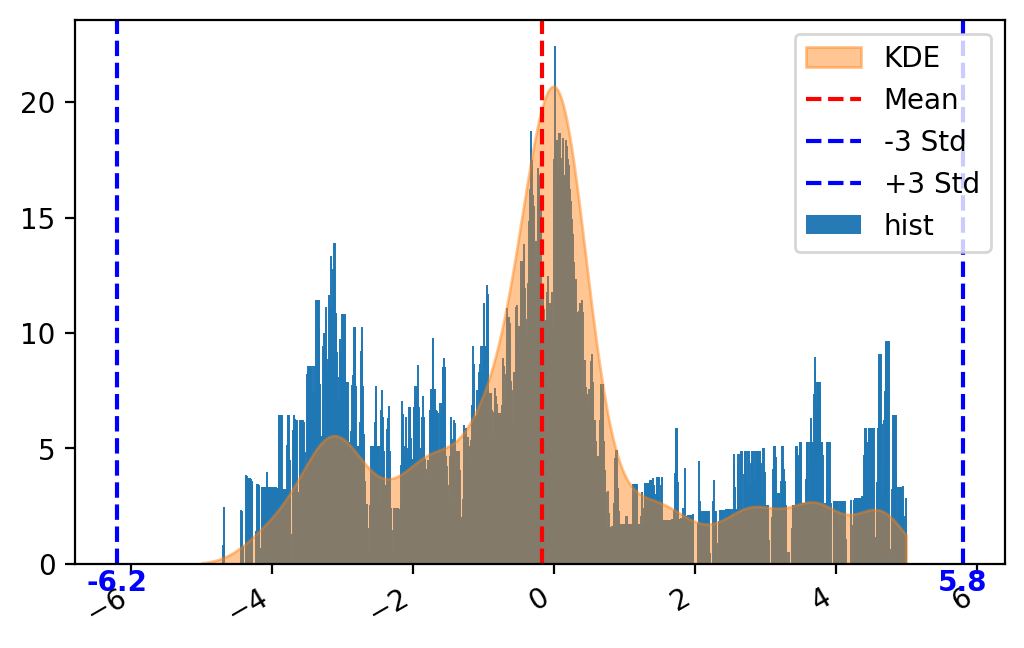

Total area of histogram: 50.71566478401422
Total area under KDE: 191.45232556027392
Scalar: 0.264899706157122


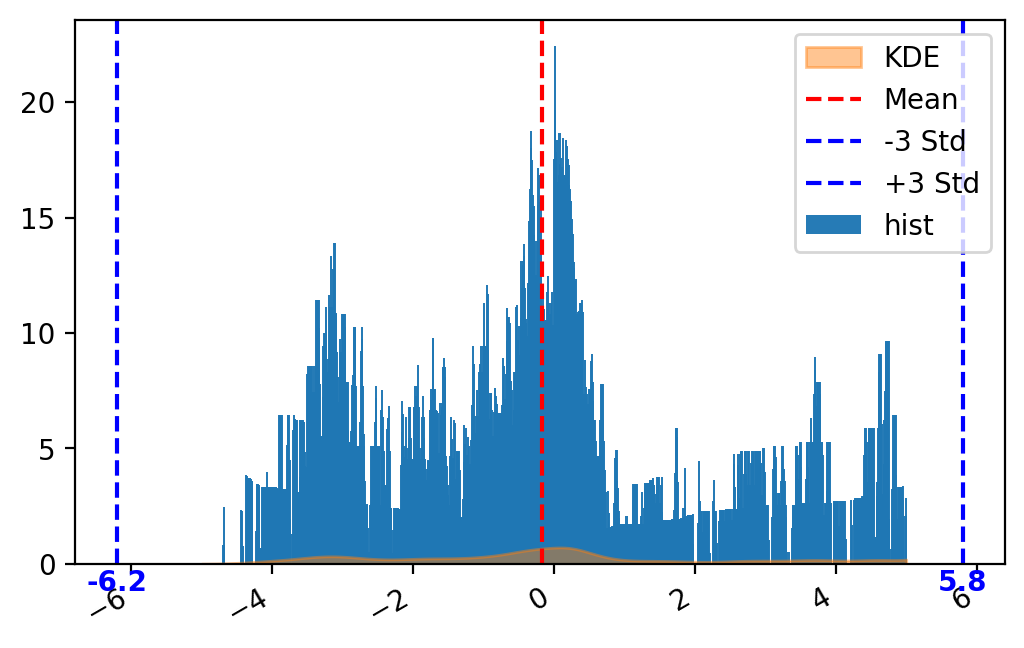

ENBH
Total area of histogram: 58.34860738217831
Total area under KDE: 0.987305219690609
Scalar: 59.09885435474853


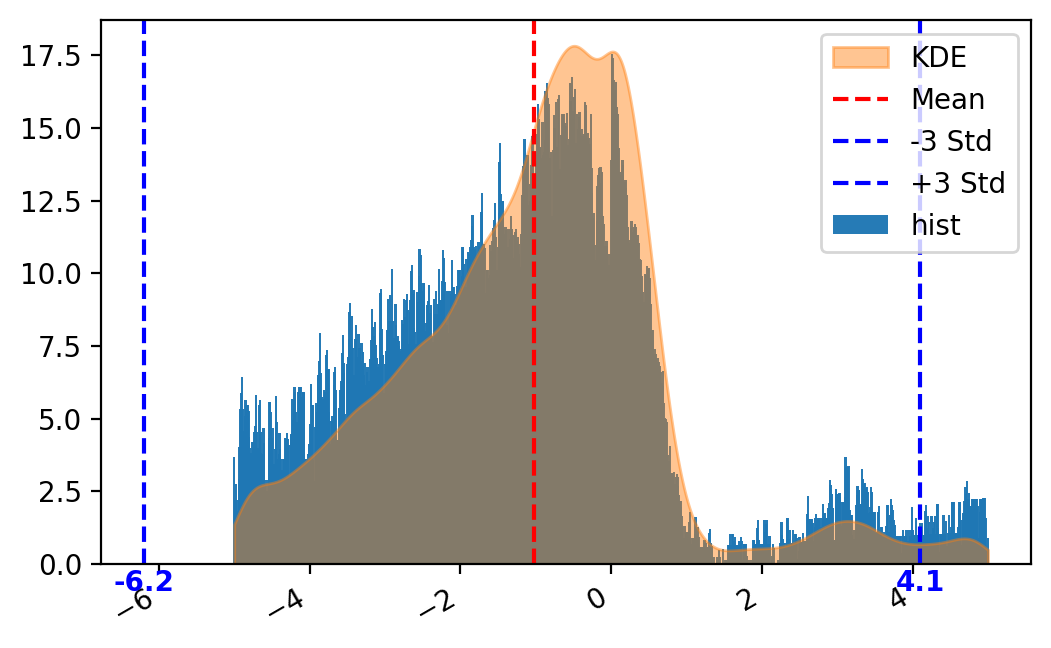

Total area of histogram: 58.34860738217831
Total area under KDE: 44.90313478601264
Scalar: 1.2994328271342415


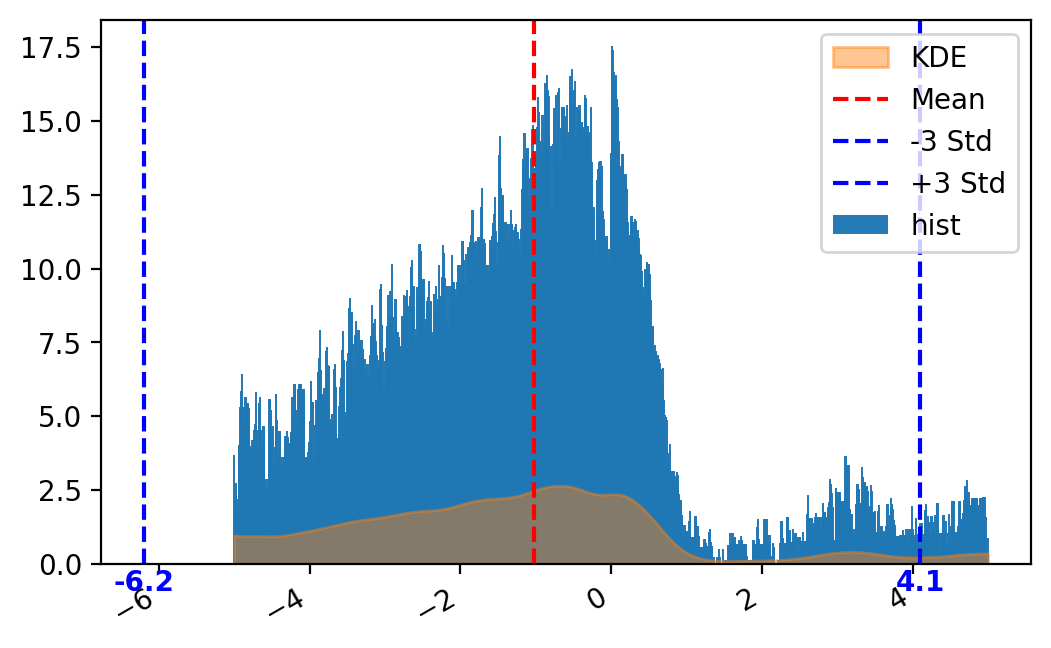

MCGH
Total area of histogram: 26.290089714601635
Total area under KDE: 0.9644671374806623
Scalar: 27.258668225104515


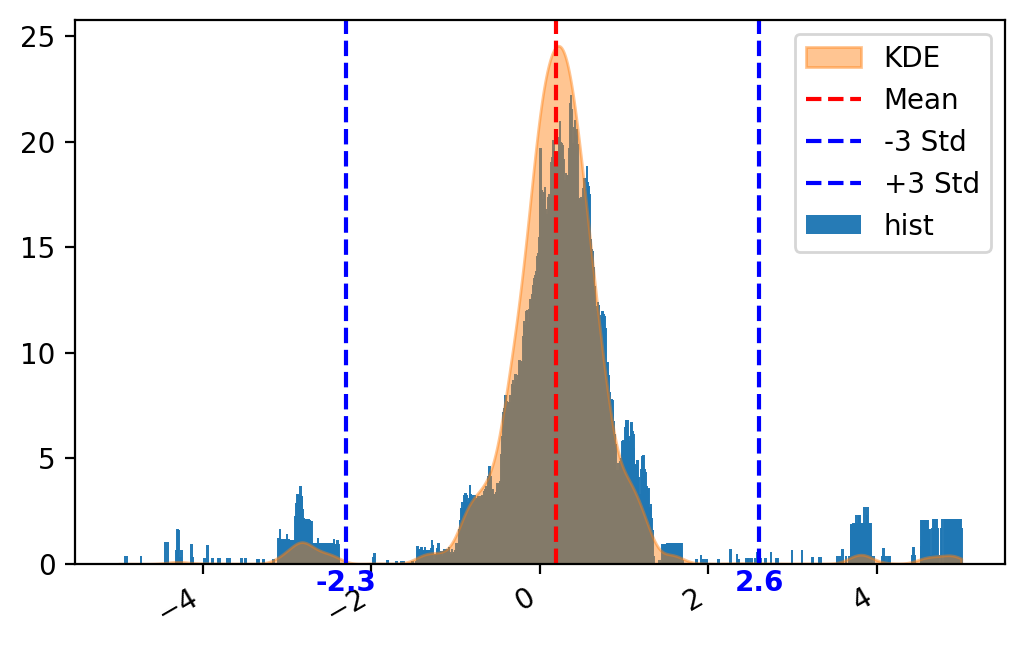

Total area of histogram: 26.290089714601635
Total area under KDE: 5.578641467377593
Scalar: 4.712632971367503


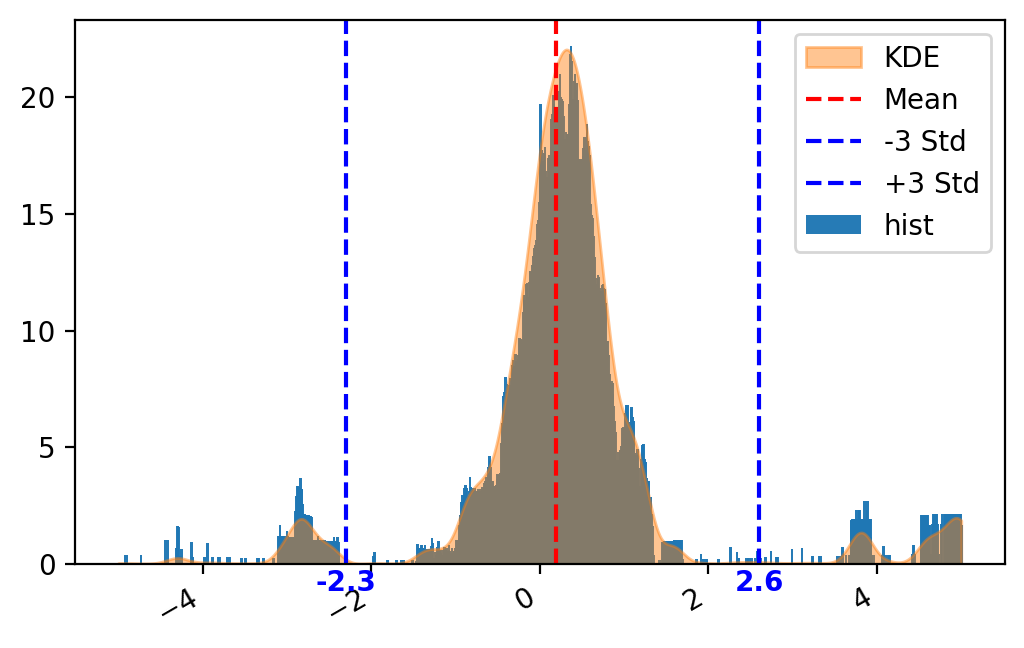

MNBH
Total area of histogram: 31.50246521279216
Total area under KDE: 0.9738854170910267
Scalar: 32.34719881820317


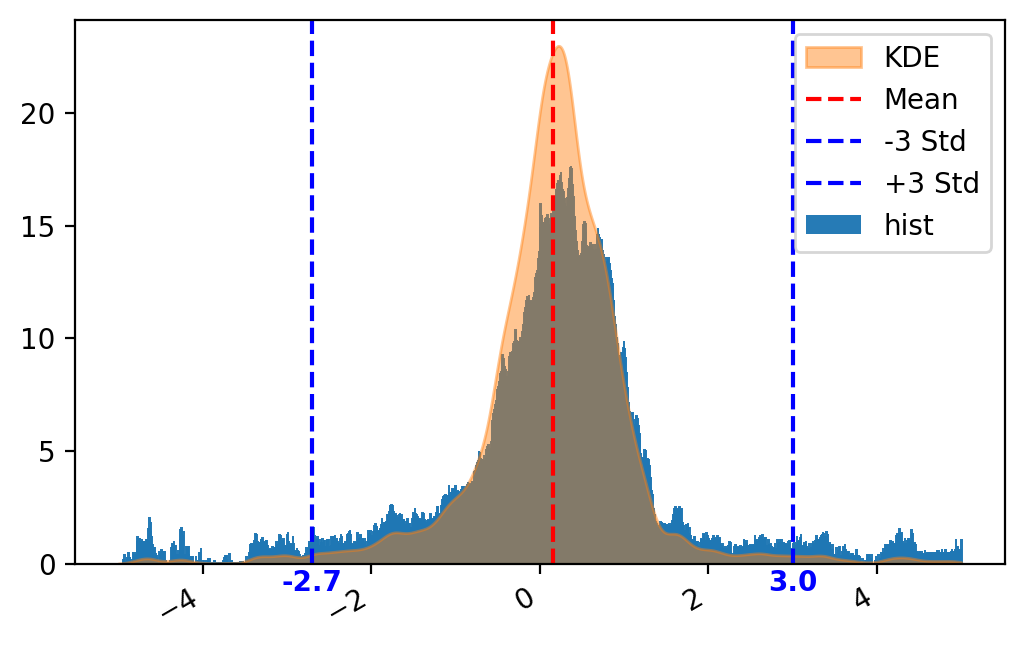

Total area of histogram: 31.50246521279216
Total area under KDE: 5.53176705220259
Scalar: 5.694828599163225


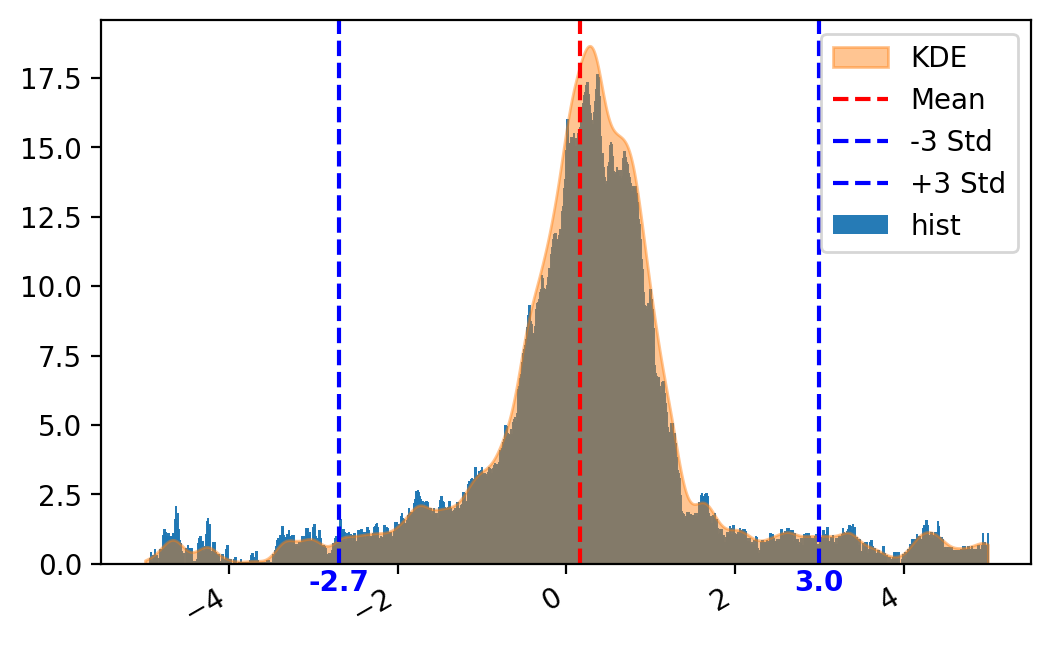

SCGM
Total area of histogram: 15.997972401157021
Total area under KDE: 0.9658426948247301
Scalar: 16.563745304363614


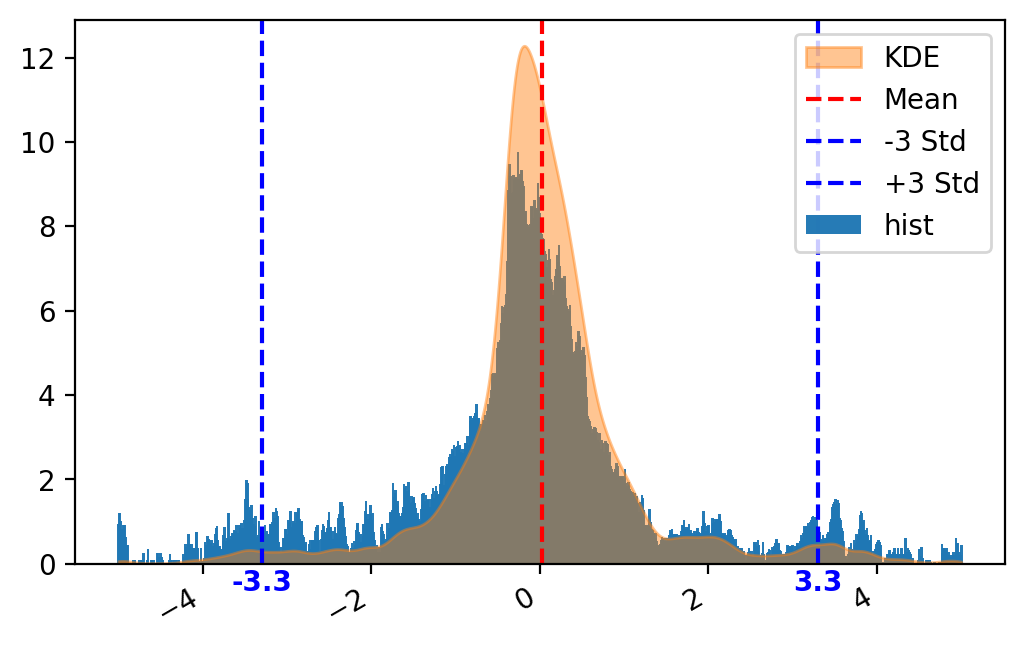

Total area of histogram: 15.997972401157021
Total area under KDE: 5.872920385206061
Scalar: 2.724023373695999


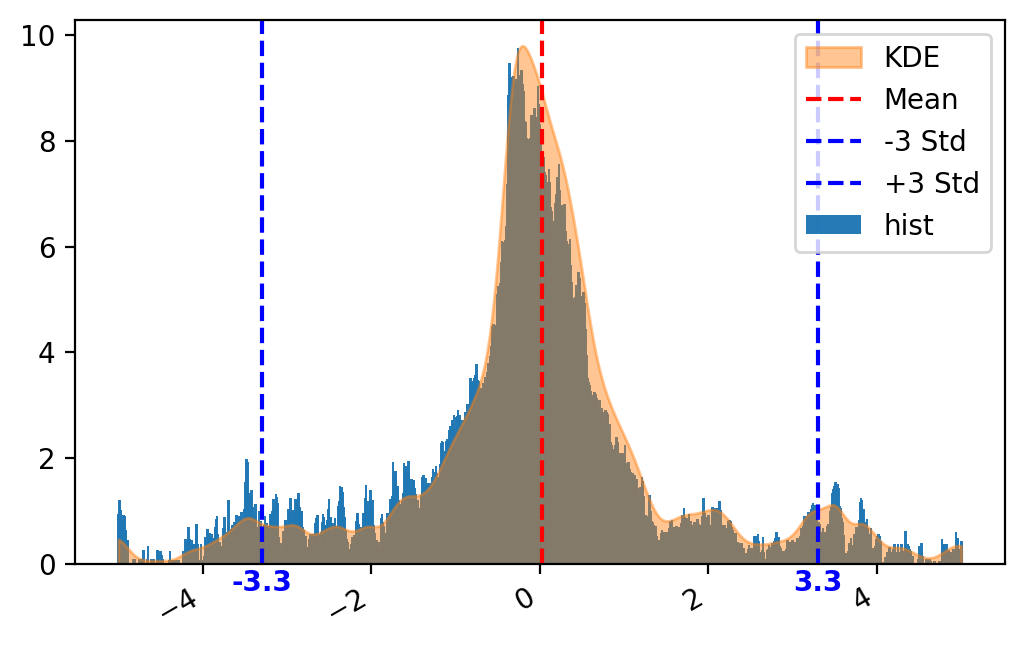

SCGA
Total area of histogram: 139.79091502159835
Total area under KDE: 0.9999999999999702
Scalar: 139.7909150216025


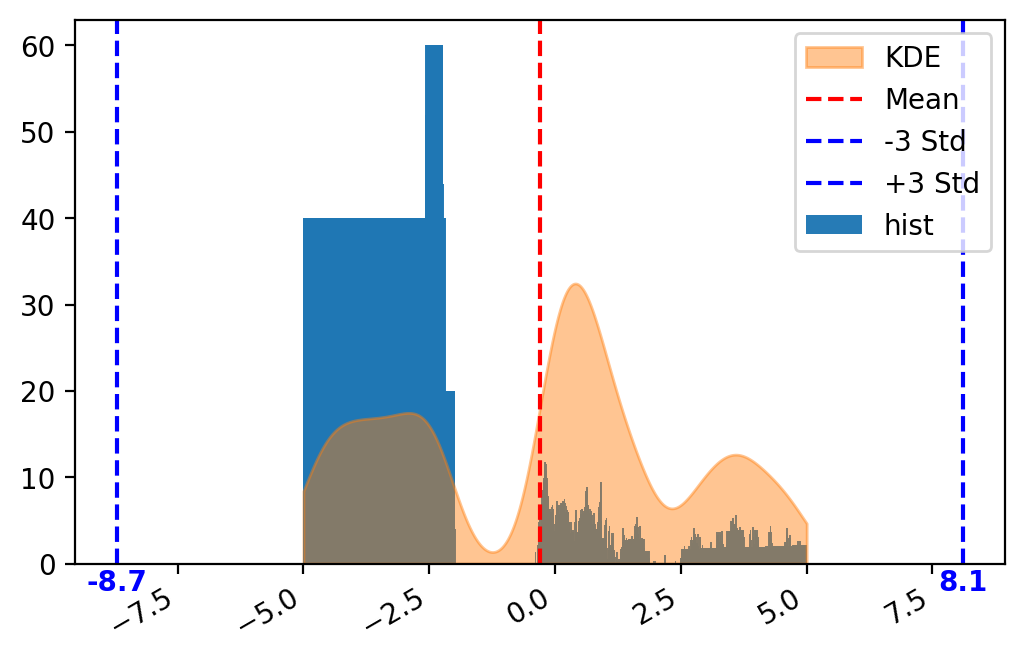

Total area of histogram: 139.79091502159835
Total area under KDE: 1.4926459219302577e+139
Scalar: 9.365309814455108e-138


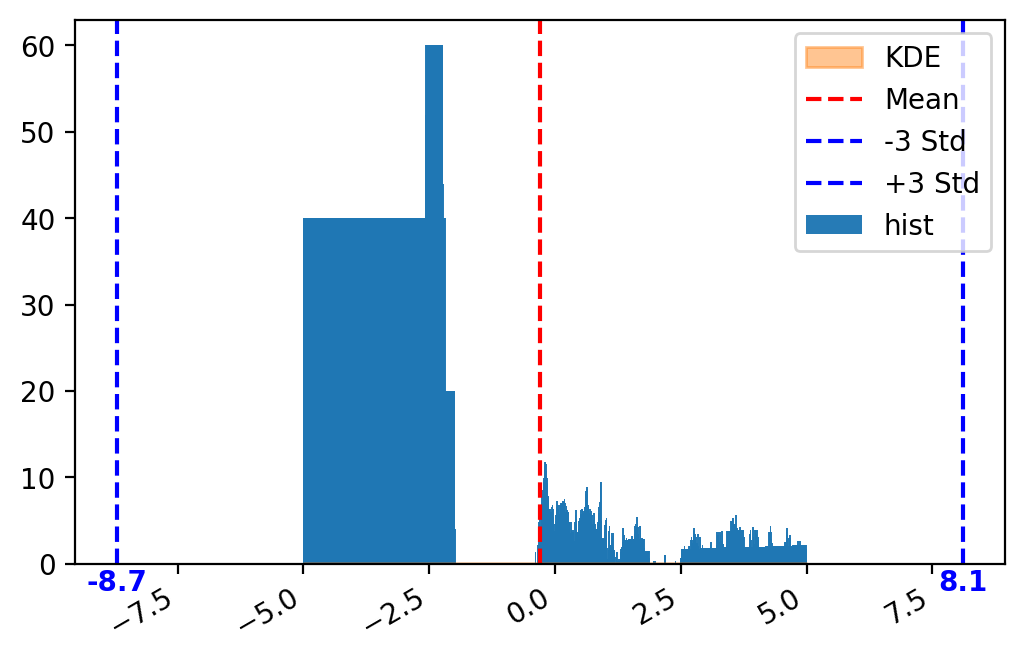

SCGR-I
Total area of histogram: 39.83003707051277
Total area under KDE: 0.994007398309007
Scalar: 40.07016158860702


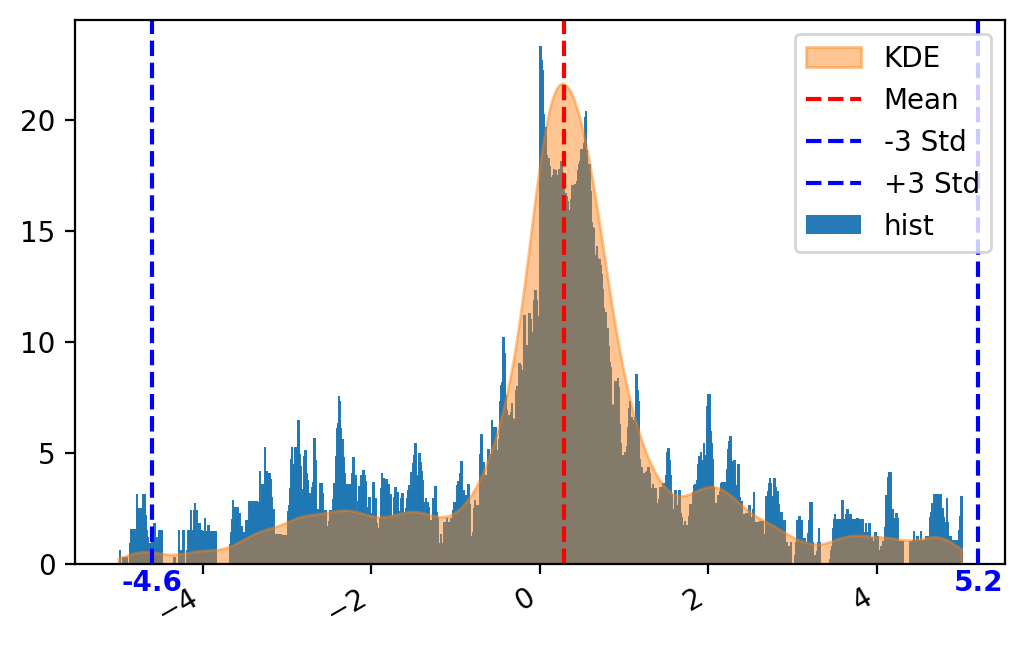

Total area of histogram: 39.83003707051277
Total area under KDE: 8.10184889620342
Scalar: 4.916166369034283


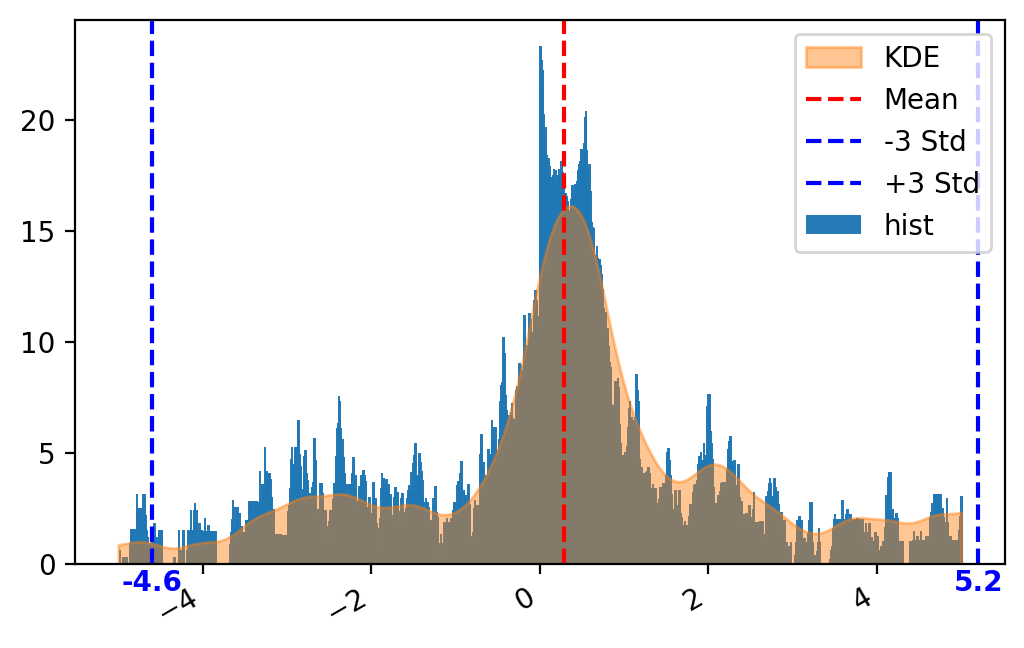

SCGR-II
Total area of histogram: 65.34211986899376
Total area under KDE: 0.9858450486290735
Scalar: 66.28031449755639


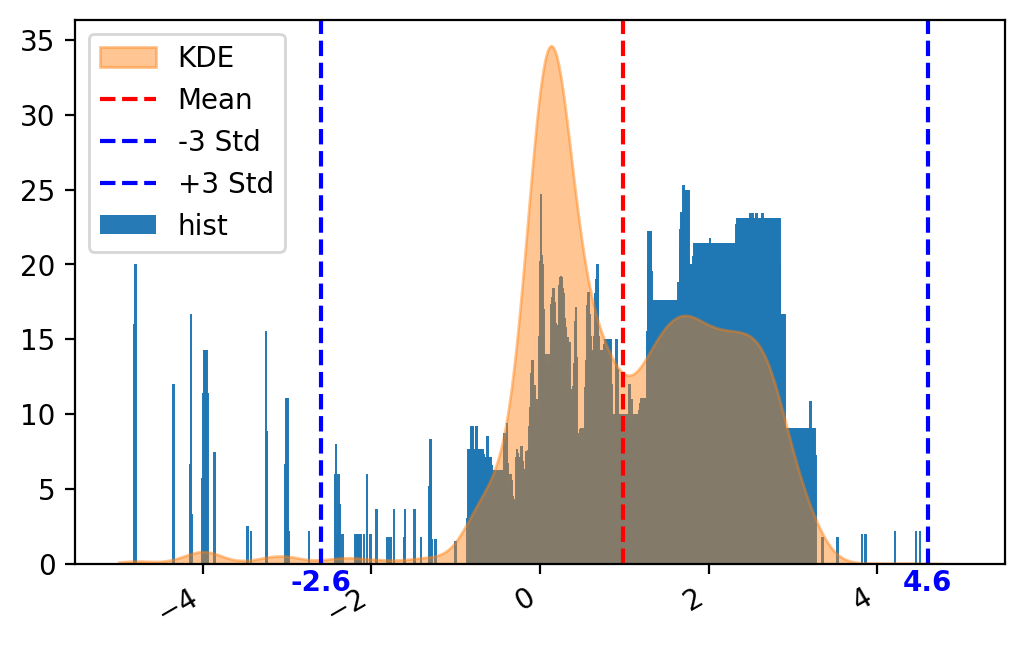

Total area of histogram: 65.34211986899376
Total area under KDE: 11.29241949145721
Scalar: 5.786370221051875


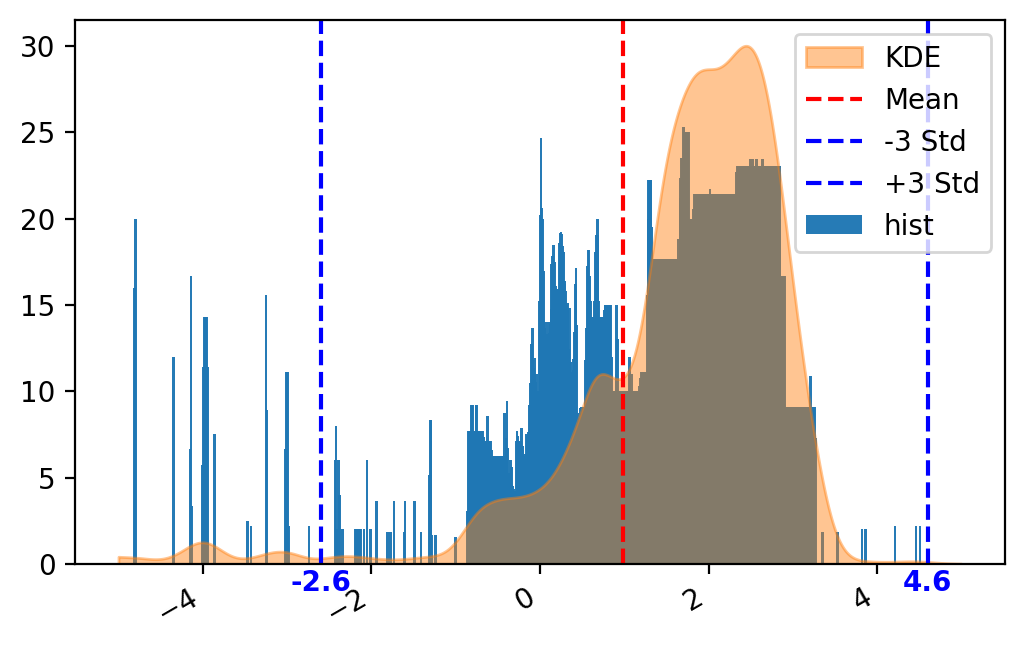

SCGC-I
Total area of histogram: 28.301730089187622
Total area under KDE: 0.9911321113162016
Scalar: 28.554952226907016


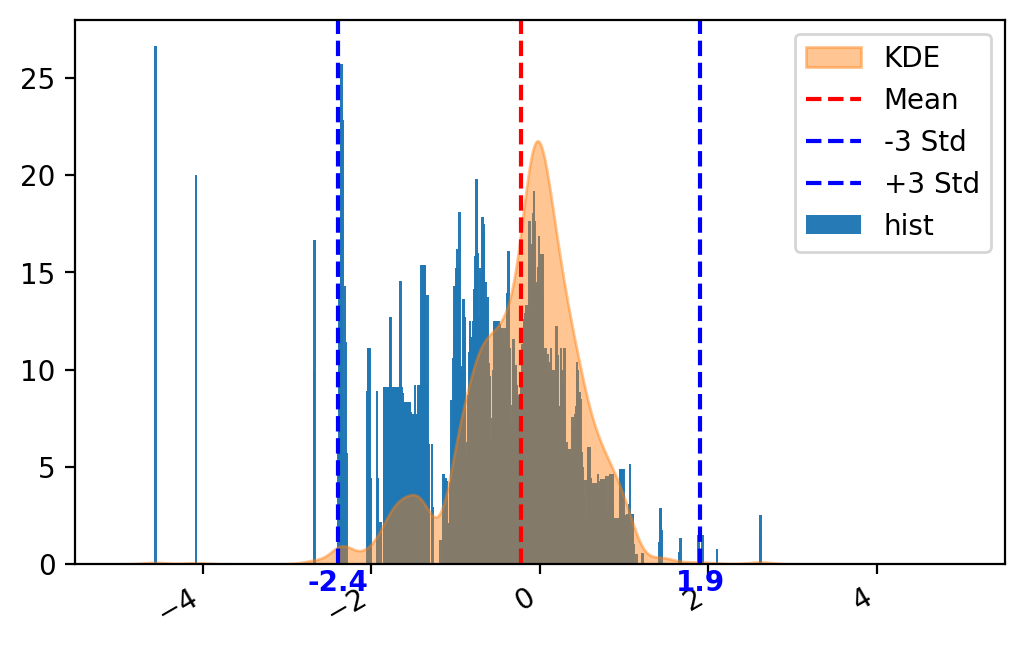

Total area of histogram: 28.301730089187622
Total area under KDE: 6.201580177918603
Scalar: 4.563632054610693


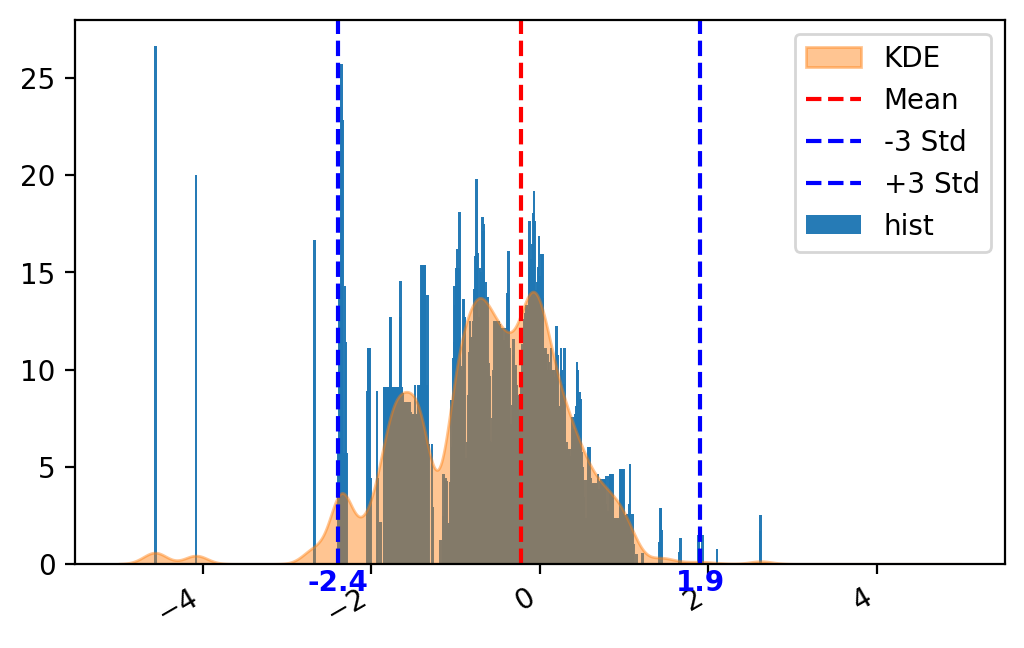

SCGC-II
Total area of histogram: 27.968420577645304
Total area under KDE: 0.9835362740293604
Scalar: 28.436592849864116


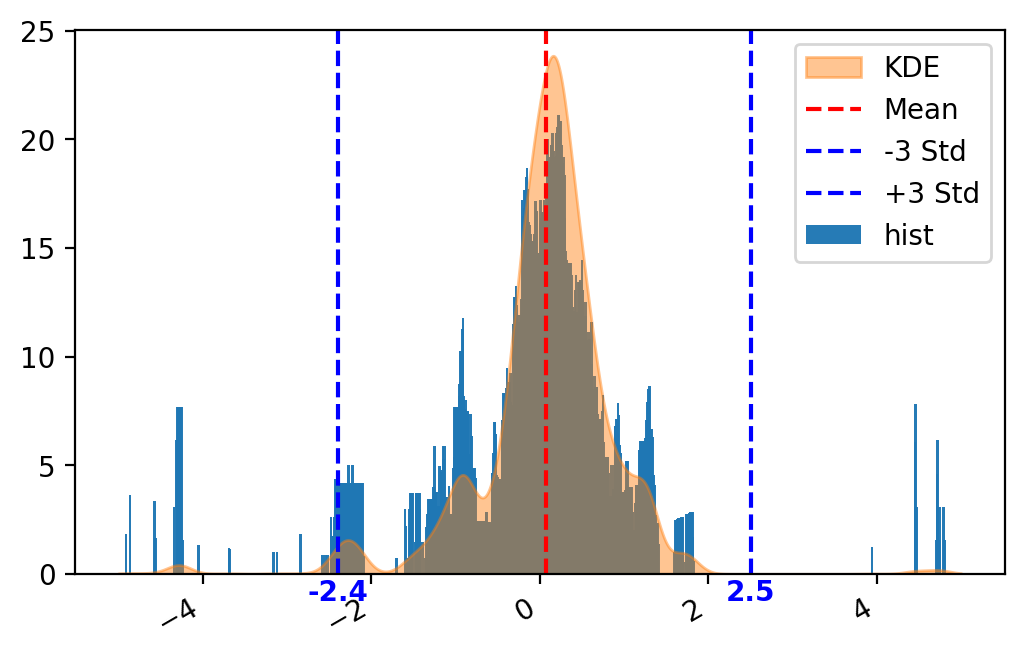

Total area of histogram: 27.968420577645304
Total area under KDE: 5.754455200679316
Scalar: 4.8603072927466044


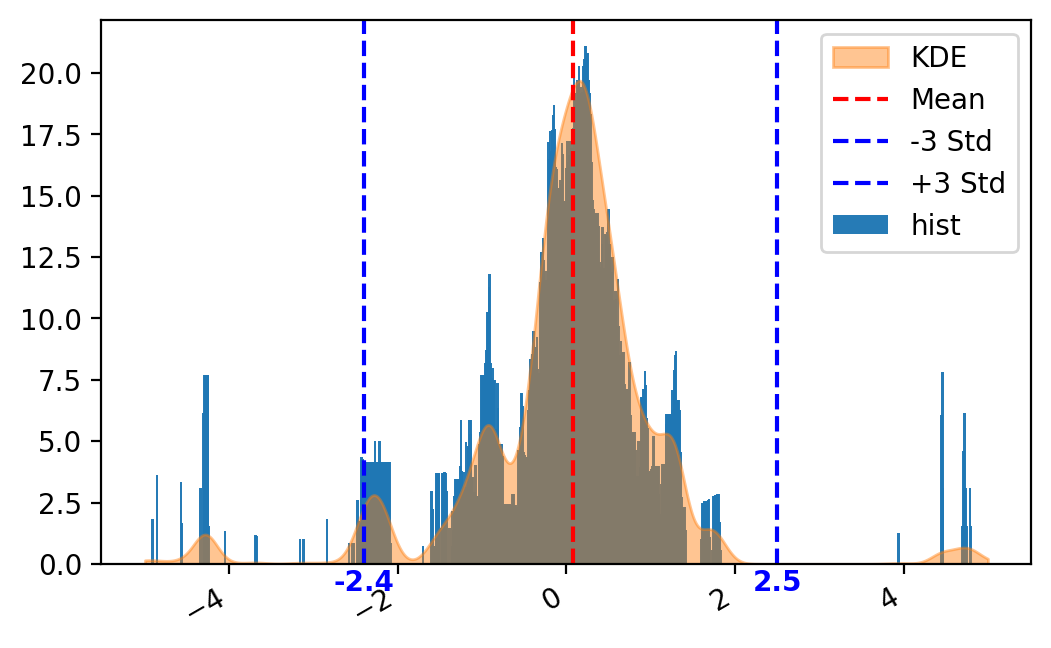

SCGF
Total area of histogram: 65.00329966694116
Total area under KDE: 0.9869102524321458
Scalar: 65.8654619371384


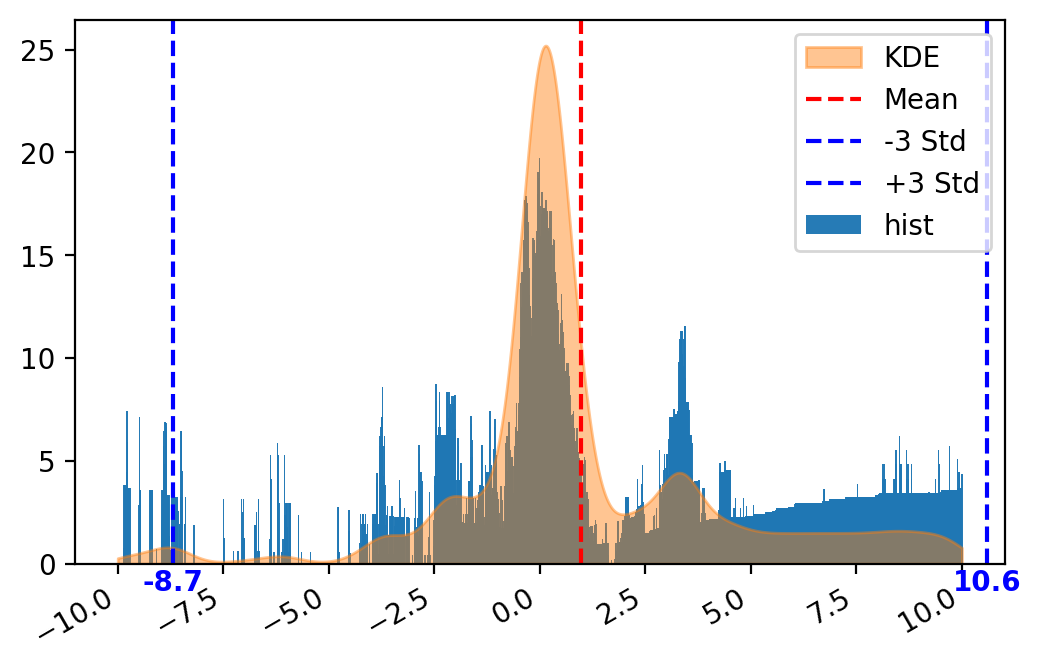

Total area of histogram: 65.00329966694116
Total area under KDE: 14.835873783781745
Scalar: 4.381494518914104


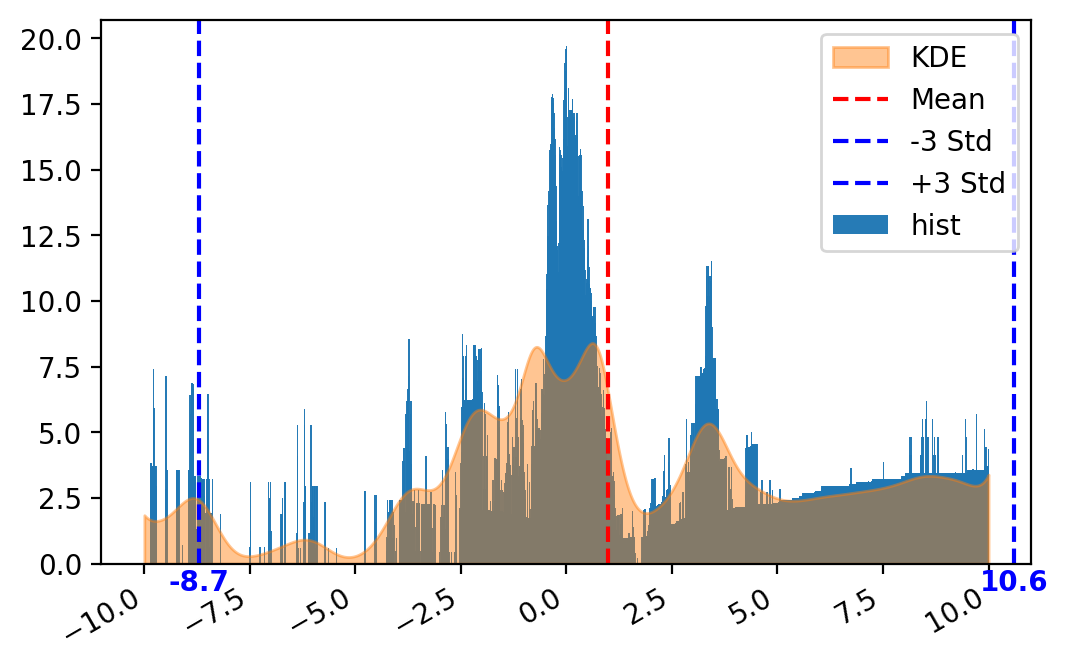

MCGF
Total area of histogram: 134.10677953679115
Total area under KDE: 0.9752480280008481
Scalar: 137.51043394744966


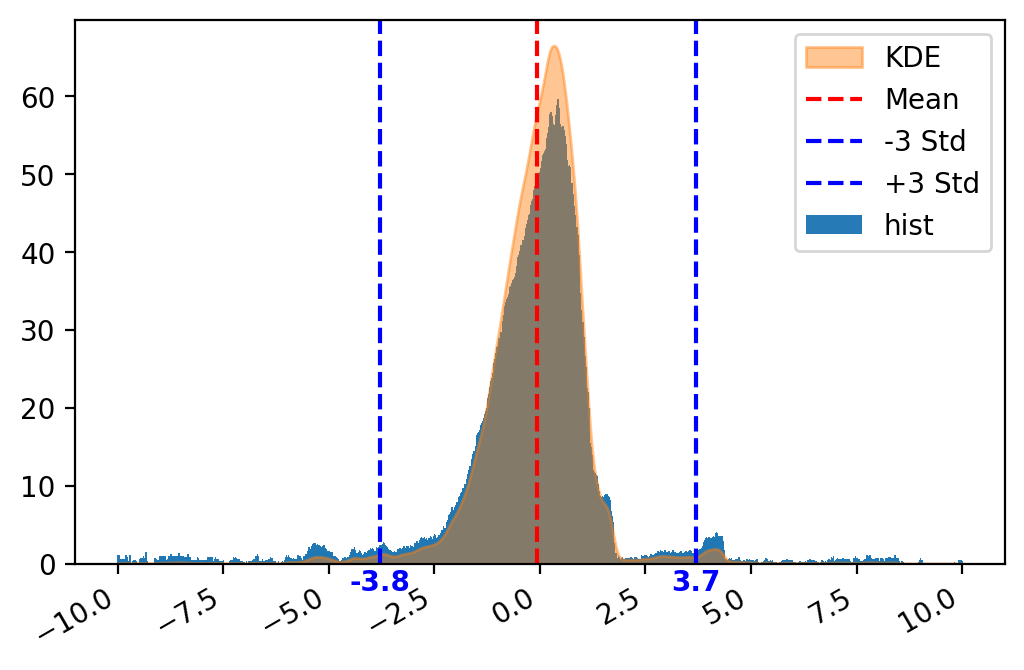

Total area of histogram: 134.10677953679115
Total area under KDE: 9.339754888186242
Scalar: 14.358704392384153


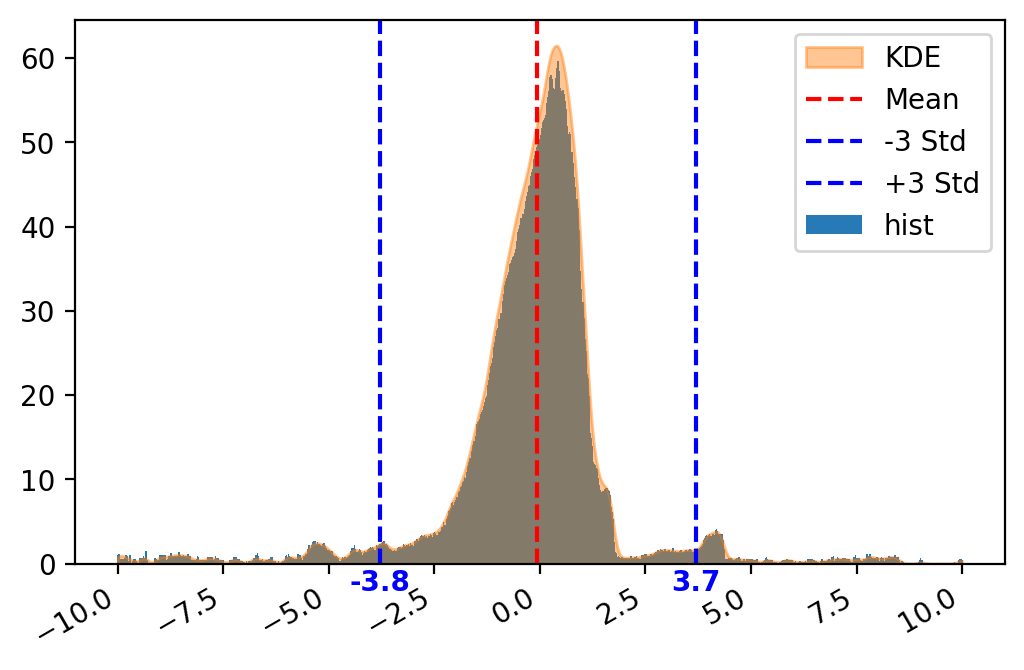

NASR
Total area of histogram: 285.7125899982452
Total area under KDE: 0.9912157289963079
Scalar: 288.2446087569192


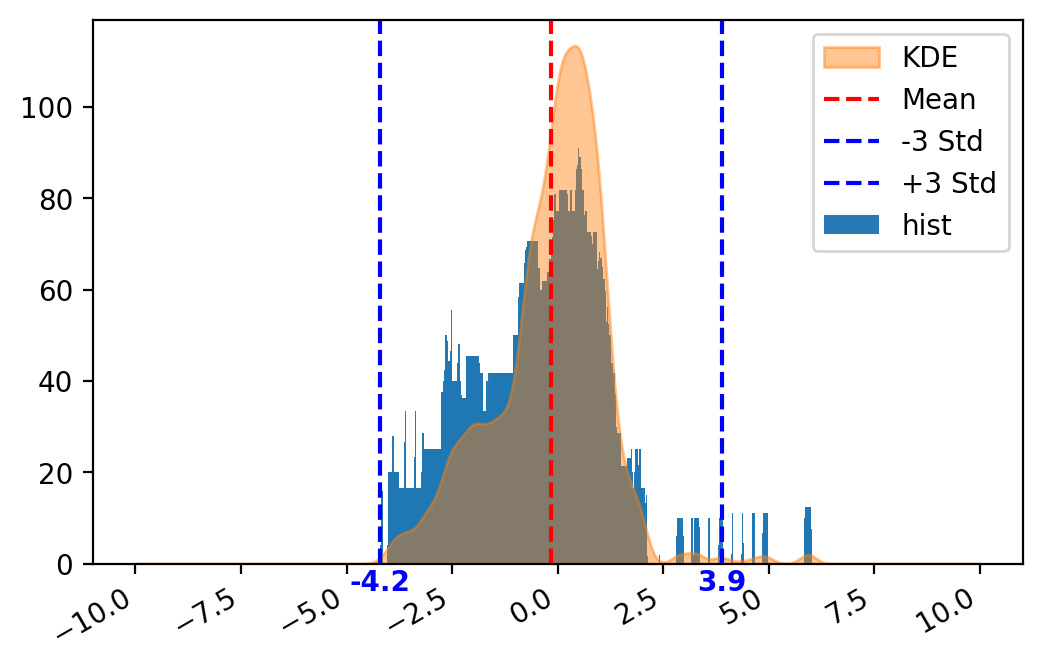

Total area of histogram: 285.7125899982452
Total area under KDE: 10.750495329483964
Scalar: 26.57669077020656


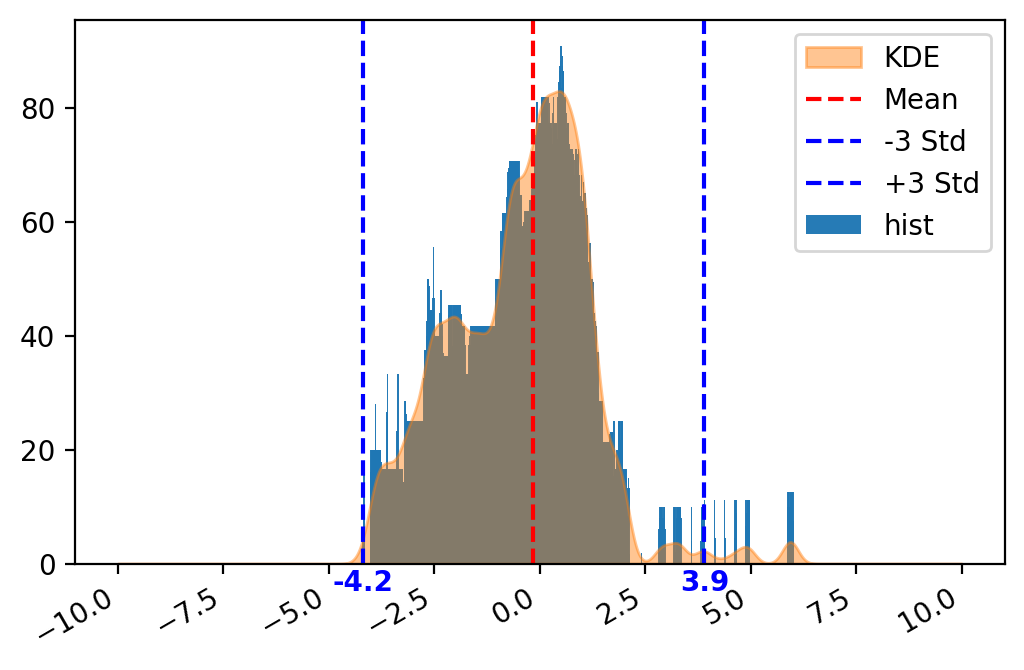

Stable
Total area of histogram: 26.23671464920044
Total area under KDE: 0.9815115188364674
Scalar: 26.73092892511618


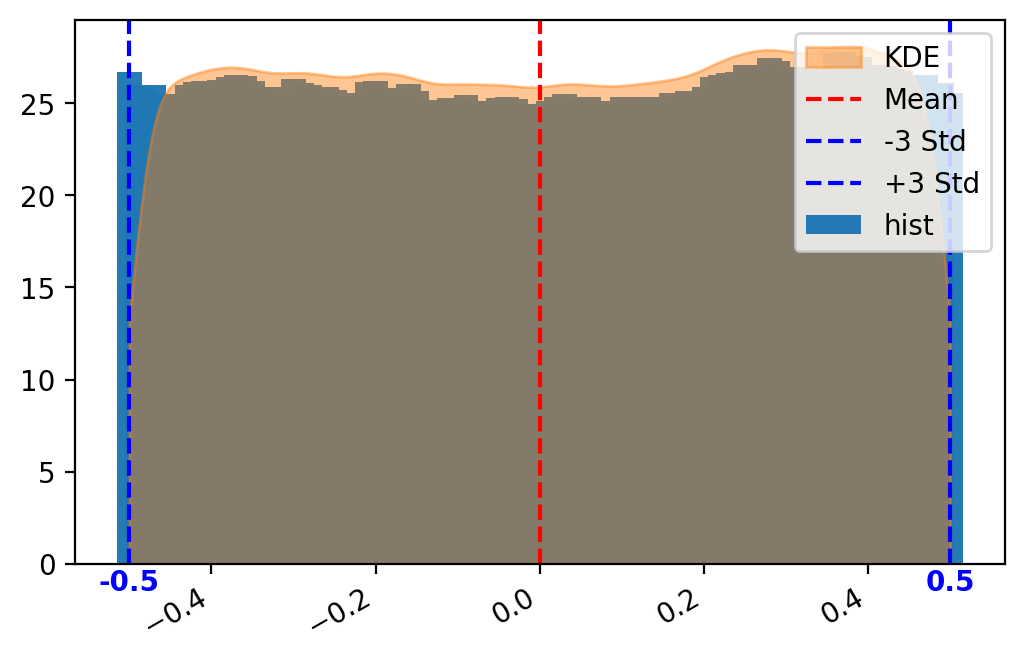

Total area of histogram: 26.23671464920044
Total area under KDE: 0.9967090489539518
Scalar: 26.32334348397451


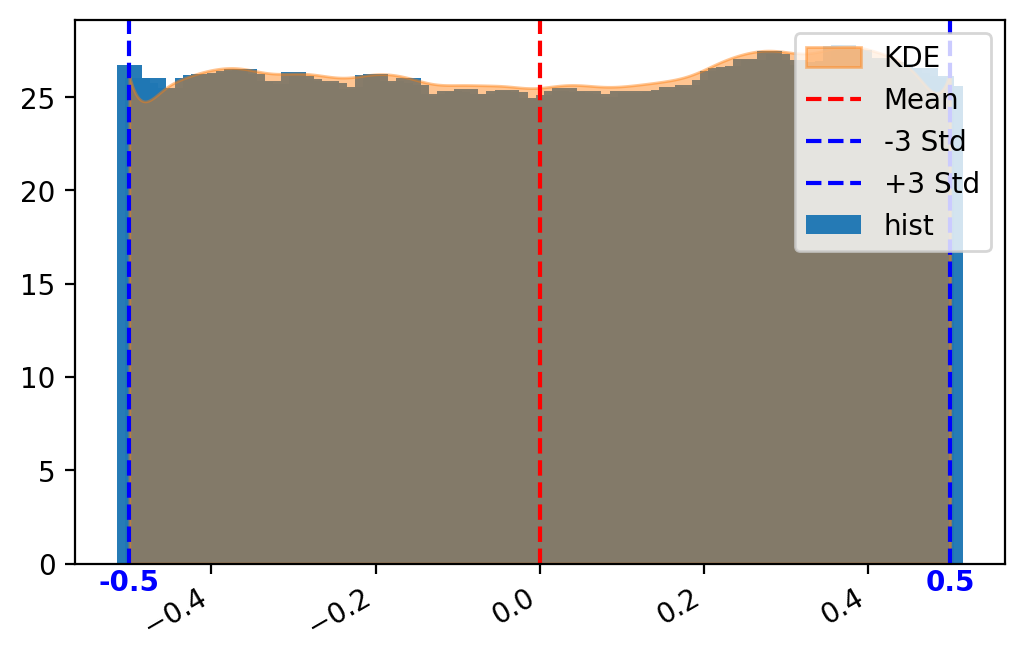

In [8]:
metrics = ['dl_lost', 'dl_excl']
for i, mode_mets in enumerate(metrics):
    mode, mets = mode_mets[:2], mode_mets[-4:]
    if mets == 'lost':
        RATE_TYPE = 'PLR'
    elif mets == 'excl':
        RATE_TYPE = 'ELR'
    
    if i > 0:
        break
    
    scope = obj.scope_agg[mode_mets]
    print(scope)
    for tag in scope.keys():
        print('===================================================================================')
        print(tag)
        
        table = obj.Profile['dl_lost'][tag]['dist_table']
        loex_data = obj.Profile['dl_lost'][tag]['relative_loex_timestamp']
        xmit_data = obj.Profile['dl_lost'][tag]['relative_timestamp']
        
        if len(loex_data) == 0:
            continue
        
        obj.plot_example1(tag, table, loex_data, xmit_data, mets, RATE_TYPE)
        obj.plot_example2(tag, table, loex_data, xmit_data, mets, RATE_TYPE)
        
        # if tag == 'Stable':
        #     mean = 0
        #     left_bound, right_bound = -0.5, 0.5
        # else:
        #     mean, std = np.mean(loex_data), np.std(loex_data)
        #     left_bound, right_bound = round(mean - 3 * std, 1), round(mean + 3 * std, 1)
        
        
        # fig, ax = plt.subplots(figsize=(6, 4))
        
        # x = np.asarray(table['window_id'], dtype=np.float64)
        # y = np.asarray(table[RATE_TYPE], dtype=np.float64)
        # # y = np.asarray(table[mets], dtype=np.float64)
        # ax.bar(x, y, label='hist', width=0.03, alpha=0.97)
        
        # # 計算直方圖的面積
        # hist_area = total_area_histogram_with_centers(x, y, 0.01)
        # print("Total area of histogram:", hist_area)
        
        # # ax_twin = ax.twinx()
        
        # # kde1 = gaussian_kde(loex_data)
        # # kde2 = gaussian_kde(xmit_data)
        # # def kde(x):
        # #     kde2_values = kde2(x)
        # #     # 檢查 kde2 是否為零，如果是則返回一個小的非零值
        # #     kde2_values[kde2_values == 0] = 1
        # #     return kde1(x) / kde2_values
        # kde = gaussian_kde(loex_data)
        
        # # 計算 KDE 下的總面積（只計算正負三個標準差內的點，理論上 scalar 會稍微高估，但不會太多）
        # kde_area = total_area_kde(kde, left_bound, right_bound)
        # # 計算 KDE 下的總面積（無窮積分）
        # # kde_area = total_area_kde(kde)
        # print("Total area under KDE:", kde_area)
        
        # scalar = hist_area / kde_area
        # print("Scalar:", scalar)
        
        # x = np.linspace(min(xmit_data), max(xmit_data), 1000)
        # # x = np.linspace(min(loex_data), max(loex_data), 1000)
        
        # density = scalar * kde(x)
        # # ax.plot(x, density, label='KDE', color='tab:orange', lw=1)
        # ax.fill_between(x, density, label='KDE', color='tab:orange', alpha=0.45)
        
        # # find the scope and boundaries
        # ax.axvline(x=mean, color='red', linestyle='--', label='Mean')
        # ax.axvline(x=left_bound, color='blue', linestyle='--', label='-3 Std')
        # ax.axvline(x=right_bound, color='blue', linestyle='--', label='+3 Std')
        
        # bottom, top = ax.get_ylim()
        # ax.text(left_bound, bottom-0.05*(top-bottom), '{:.1f}'.format(left_bound), ha='center', fontweight='bold', fontsize=10, color='blue')
        # ax.text(right_bound, bottom-0.05*(top-bottom), '{:.1f}'.format(right_bound), ha='center', fontweight='bold', fontsize=10, color='blue')
        
        # ax.legend()
        
        # plt.gcf().autofmt_xdate()
        # plt.show()
        # # break

In [9]:
class Player:
    def __init__(self, name, items=[]):
        self.name = name
        self.items = items.copy()
        print(id(self.items))

p1 = Player('Alice')
p2 = Player('Bob')
p3 = Player('Charlie', ['swords'])

140313949204928
140305462230336
140300478953216
